In [47]:
# basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# for pre-processing
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
import string

# for topic modeling
import gensim
from gensim import corpora

# for wordcloud
from wordcloud import WordCloud

# TDM, TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# SVD
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

# Clustering, K-Means
from sklearn.cluster import KMeans

# topic modeling
import gensim 
from gensim import corpora

# collocation, bigram, trigram
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

# kmeans model saving
from sklearn.externals import joblib

# cluster exploration, visualization
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import mpld3


In [48]:
path_dir = os.getcwd()
data_file_name = '/processed_data_1014.csv'

In [49]:
data = pd.read_csv(path_dir + data_file_name)
data = data.rename(columns = {'Unnamed: 0' : 'index', 'category':'industry', 'seniority':'title'})
data['salary_avg'] = (data.salary_max + data.salary_min)/2
data.head(5)

,industry,company,employment_type,job_description,job_requirement,job_skills,job_title,job_uuid,location,salary_max,...,job_description_nn,job_requirement_nnp,job_description_nnp,job_requirement_vb,job_description_vb,latitude,longtitude,job_experience,job_degree,salary_avg
0,Engineering ...,PROPERTYGURU PTE. LTD.,Permanent,Our websites attract more than 100 million mon...,Bachelor’s degree in IT or relevant field. Alt...,"Data Analysis, SQL, Microsoft Excel, Microsoft...",Data Engineer,82e462a13cadc477f93d57ad6812d1d1,Central,7000.0,...,websites page-views click-stream behaviour dat...,IT Azkaban Airflow Python C++ Java Go Scala Ka...,Property Guru Southeast Asia.Our Data Science ...,be working Working authoring write is is be is...,attract result has is empowered build using be...,1.300213,103.837286,2,Bachelor,6000.0
1,Engineering ...,PROPERTYGURU PTE. LTD.,Permanent,Our websites attract more than 100 million mon...,Bachelor’s degree in IT or relevant field. Alt...,"Data Analysis, SQL, Microsoft Excel, Microsoft...",Data Engineer,763708ca5a581db4389a766ef71654a0,Central,9000.0,...,websites page-views click-stream behaviour dat...,IT Azkaban Airflow Python C++ Java Go Scala Ka...,Property Guru Southeast Asia.Our Data Science ...,be working Working authoring write is is be is...,attract result has is empowered build using be...,1.300213,103.837286,2,Bachelor,8000.0
2,"Accounting ,Auditing ,Taxation",ERNST & YOUNG ADVISORY PTE. LTD.,Permanent,Join Fraud Investigation & Dispute Services (F...,To qualify for the role you must have. Strong ...,"Accounting, Microsoft Excel, Microsoft Word, G...",Fraud Investigation & Dispute Services (FIDS) ...,c59d6037f441a5b3b43ca4daff84806a,Central,16000.0,...,Fraud Investigation Dispute Services Assurance...,Life Science English Plus Opportunities,Fraud Investigation Dispute Services Assurance...,qualify have is encouraged apply run managing ...,Join help work be aligned works experience tai...,1.280895,103.851677,eight,NaN,12000.0
3,"Sciences ,Laboratory ,R&D",A*STAR RESEARCH ENTITIES,Contract,"The Agency for Science, Technology and Researc...",Bachelor or Master's Degree in physical scienc...,"Matlab, Algorithms, C++, Machine Learning, C, ...",Research Engineer / Senior Research Engineer (...,cec1905d6444838c2d7108c1a04049a3,West,5000.0,...,Agency Science Technology Research ( A*STAR ) ...,Technical,Agency Science Technology Research ( A*STAR ) ...,building been specialise interpret seek develo...,is fosters drive transform .For please advance...,1.285407,103.850568,5,"Bachelor, Master",3750.0
4,"Sciences ,Laboratory ,R&D",A*STAR RESEARCH ENTITIES,Contract,"Specialize in applying data analytics, machine...",PhD in Power System operation and analysis or ...,"R&D, Molecular Biology, Biotechnology, Lifesci...","Scientist (Power System Analytics), EPGC",d2da04bb4033006cb580fc80e752fa9e,West,11800.0,...,data analytics machine learning data mining te...,Power System C/C++ Python Jurong Island,NaN,related work work are ) are include based be a...,Specialize applying be prepare,1.285407,103.850568,NaN,"Master, PhD",8850.0


In [50]:
# check column names
list(data.columns.values)

['industry',
 'company',
 'employment_type',
 'job_description',
 'job_requirement',
 'job_skills',
 'job_title',
 'job_uuid',
 'location',
 'salary_max',
 'salary_min',
 'title',
 'job_requirement_nn',
 'job_description_nn',
 'job_requirement_nnp',
 'job_description_nnp',
 'job_requirement_vb',
 'job_description_vb',
 'latitude',
 'longtitude',
 'job_experience',
 'job_degree',
 'salary_avg']

In [51]:
# # return unique values of each column in list 'column_name' 
# def UniqueColumnValues(column_name, data):
#     for i in column_name:
#         print('ColumnName %s:'% i , end = '')
#         print(data[i].unique())
        
# column_name = ['job_title']
# UniqueColumnValues(column_name, data)
# len(data['job_title'].unique())

In [52]:
# raw text

req = data.job_requirement
req_nn = data.job_requirement_nn
req_nnp = data.job_requirement_nnp
req_vb = data.job_requirement_vb
skill = data.job_skills
industry = data.industry
title = data.job_title

#reqcmb = data[['job_requirement_nn','job_requirement_vb']].apply(lambda x: ''.join(x), axis = 1)

# The Definitions of pre-processing functions

In [53]:
# define pre-processing funciton

stop = stopwords.words('english') + ['...','singapore','one','like','plus','etc','may','time','a*star','experience',
                                    'machine', 'learning','data','skill','ability'] # define set of stop words
# snowball = nltk.SnowballStemmer('english')
wnl = nltk.WordNetLemmatizer() # stemming method


def preprocess (text): 
    '''
    Parameter Description:
    - input 
    text: raw text 
    '''   
    toks = word_tokenize(text) # tokenization
    toks = [t.lower() for t in toks if t not in string.punctuation] # remove punctuation and tolower
    toks = [ wnl.lemmatize(t) for t in toks ] # stemming
    toks = [t for t in toks if t not in stop] # remove stop words
#    toks = [ snowball.stem(t) for t in toks ]
   
    toks_clean = [t for t in toks if len(t) >= 3] # remove words with the number of characters less 3
    return toks_clean

def FrequencyDistribution (text, top_n):
    '''
    Parameter Description:
    - input 
    text: raw text 
    top_n: the number of terms to be shown
    - return:
    a list contained top_n high frequecy terms  
    ''' 
    toks = text.apply(preprocess)
    flat_toks = [c for l in toks for c in l]
    fd = nltk.FreqDist(flat_toks)
#     fd.plot(top_n)
    print(fd.most_common(top_n))
    return fd.most_common(top_n)

def WordCloudVisualization(text):
    '''
    Parameter Description:
    - input 
    text: raw text  
    ''' 
    toks = text.apply(preprocess)
    flat_toks = [c for l in toks for c in l]
    fd = nltk.FreqDist(flat_toks)
    wc = WordCloud(background_color = 'white').generate_from_frequencies(fd)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def TfIdfVectorizor(text, mindf, maxdf, ngramrange):
    '''
    Parameter Description:
    - input 
    text: raw text 
    mindf: terms with # of character < mindf will be excluded
    maxdf: terms with a document frequecny higher than threshold maxdf will be excluded
    - return:
    tfidf: tfidf matrix
    vec_tfidf: vectorizer
    ''' 
    toks = text.apply(preprocess)
    comb = toks.apply(lambda x: " ".join(x))
    vec_tfidf = TfidfVectorizer(min_df=mindf, max_df=maxdf, ngram_range=ngramrange)
    tfidf = vec_tfidf.fit_transform(comb)
    #tfidf_desc.toarray()[:10] 
    return tfidf, vec_tfidf

# def view_topidf(top_n, text, mindf, maxdf):  

#     tfidf, vec = TfIdfVectorizor(text, mindf, maxdf)
#     indices = np.argsort(vec.idf_)[::-1]
#     feature = vec.get_feature_names()
#     top_features = [feature[i] for i in indices[:top_n]]
#     print(top_features)  
    
def TfIdfTopTermsPerDocument(top_n, text, mindf, maxdf):
    '''
    Parameter Description:
    - output 
    for each document, print the top_n # of terms with high tfidf value
    '''
    toks = text.apply(preprocess)
    tfidf, vec = TfIdfVectorizor(text, mindf, maxdf)
    indices = np.argsort(tfidf.toarray())[:, ::-1]
    features = vec.get_feature_names()
    for d in range(toks.count()):
        print("Document %d:" % d, end='')
        for i in range(top_n): 
            top_features = [features[i] for i in indices[d,:top_n]]
        print(top_features)
        return top_features
        

# Definition of Collocation Function

In [54]:
# Collocation, bigram, trigram

bimeasure = BigramAssocMeasures.likelihood_ratio
trimeasure = TrigramAssocMeasures.likelihood_ratio

def FliterCollocationBigram(text, top_n, wd_size):
    toks = text.apply(word_tokenize)
    toks = [w.lower() for l in toks for w in l]
    bcf = BigramCollocationFinder.from_words(toks, window_size = wd_size)
    stopset = set(stop)
    filtering = lambda w: len(w) < 3 or w in stopset or w.isdigit()
    bcf.apply_word_filter(filtering)
    top = bcf.nbest(bimeasure, top_n)
    print(top)
    return bcf


def FliterCollocationTrigram(text, top_n, wd_size):
    toks = text.apply(word_tokenize)
    toks = [w.lower() for l in toks for w in l]
    tcf = TrigramCollocationFinder.from_words(toks, window_size = wd_size)
    stopset = set(stop)
    filtering = lambda w: len(w) < 3 or w in stopset or w.isdigit()
    tcf.apply_word_filter(filtering)
    top = tcf.nbest(trimeasure, top_n)
    print(top)
    return tcf

# Step1: Exploration
1. Frequeny distribution
2. wordcloud
3. tfidf matrix

[('science', 178), ('computer', 172), ('knowledge', 141), ('degree', 127), ('team', 124), ('year', 123), ('python', 115), ('engineering', 108), ('communication', 103), ('system', 99), ('development', 94), ('programming', 93), ('language', 90), ('technology', 83), ('software', 75), ('management', 70), ('java', 70), ('research', 68), ('environment', 67), ('business', 67)]


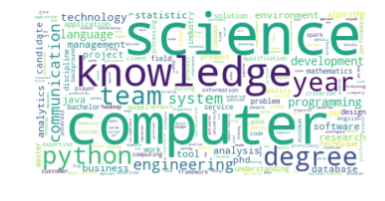

(216, 667)

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

top_features = FrequencyDistribution(req_nn, 20)
top_features
WordCloudVisualization(req_nn)

tfidf, vec_tfidf = TfIdfVectorizor(req_nn, 3, 0.7, (1,1))
tfidf.shape

In [56]:
# collocation, bigram
FliterCollocationBigram(req_nn, 20, 3)

[('computer', 'science'), ('communication', 'skills'), ('recruitment', 'policies'), ('degree', 'computer'), ('team', 'player'), ('bachelor', 'degree'), ('programming', 'languages'), ('science', 'engineering'), ('master', 'degree'), ('selection', 'recruitment'), ('tensor', 'flow'), ('phd', 'computer'), ('languages', 'java'), ('eligibility', 'criteria'), ('track', 'record'), ('languages', 'python'), ('criteria', 'recruitment'), ('computer', 'vision'), ('criteria', 'selection'), ('selection', 'criteria')]


# The Definitions of SVD and Clustering functions

In [57]:

def DimensionReductionSVD(dim_no, text, mindf, maxdf, ngramrange):
    '''
    Parameter Description:
    - input: 
    dim_no: dimension after SVD
    - return 
    tfidf_svd: tfidf matrix after SVD
    svd: SVD model
    '''
    tfidf, vec = TfIdfVectorizor(text, mindf, maxdf, ngramrange)
    svd = TruncatedSVD(dim_no)
    normalizer = Normalizer(copy=False)
    model = make_pipeline(svd, normalizer)
    tfidf_svd = model.fit_transform(tfidf)
    
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))
    
    return tfidf_svd, svd

def ClusteringKmeans(cluster_n, dtm):
    '''
    Parameter Description:
    - input:
    cluster_n: # of clusters
    dtm: dictionary term matrix
    - return
    km: kmeans model
    '''
    random_state=27
    km = KMeans(n_clusters=cluster_n, init='k-means++', max_iter=1000, n_init=1)
    km.fit(dtm)
    return km

def ClusterCloestWordsReturn(cluster_model, cluster_return_no, vec, term_no):
    '''
    Parameter Description:
    - input:
    cluster_return_no: the number of cluster showed in output
    vec: vectorizer
    term_no: the number of terms show in each cluster
    - output: 
    return terms most closed to each cluster center
    '''
    original_space_centroids = cluster_model.cluster_centers_
    order_centroids = original_space_centroids.argsort()[:, ::-1] # each cluster centre is a document, order terms by tfidf values
    terms = vec.get_feature_names()
    for i in range(cluster_return_no):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :term_no]:
            print(' %s' % terms[ind], end='')
        print()

def ClusterTopWordsReturnSVD(cluster_model, svd, cluster_return_no, vec, term_no):
    '''
    same function as the above one, the only difference is that SVD will be applied before clustering
    '''
    original_space_centroids = svd.inverse_transform(cluster_model.cluster_centers_) 
    order_centroids = original_space_centroids.argsort()[:, ::-1] # each cluster centre is a document, order terms by tfidf values
    terms = vec.get_feature_names()
    for i in range(cluster_return_no):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :term_no]:
            print(' %s' % terms[ind], end=',')
        print()
        
        

def ClusterCloestWordsReturn(cluster_n, top_n):
    column = data['job_requirement_nn'].fillna('None', inplace = True)
    for i in range(cluster_n):
        cluster = data.loc[data.kmeans == i].job_requirement_nn
        count = len(cluster)
        print("Cluster %d:" % i)
        print("Number of Recordsr %d:" % count)
#         FliterCollocationBigram(cluster, 10, 3)
#        FrequencyDistribution (cluster, 10)
#         print("Average Salary %d:" % np.mean(cluster))
        
           
        top_features = FrequencyDistribution(cluster, top_n)
        WordCloudVisualization(cluster)



# Step 2: Clustering
  1. Clustering(kmeans)
  2. K = 5
  3. ps: 'joblib.dump' is used to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

In [58]:
# # tfidf_svd, svd = DimensionReductionSVD(100, req, 3, 0.7, (1,1))
# # km = ClusteringKmeans(5, tfidf_svd)
# # ClusterTopWordsReturnSVD(km, svd, 5, vec_tfidf, 10)

# km = ClusteringKmeans(5, tfidf)
# ClusterCloestWordsReturn(km, 5, vec_tfidf, 10)

# joblib.dump(km,  'doc_cluster5.pkl')
# clusters = km.labels_.tolist()
km = joblib.load('doc_cluster5.pkl')
data['kmeans'] = km.labels_


# data.to_csv('/Users/Janet/Desktop/EBAC/courses/semester 2/<ELECTIVE>TEXT MINING/CA/kmean_4_4444.csv', index = False)
# km = ClusteringKmeans(3, tfidf)
# ClusterTopWordsReturn(km, 3, vec_tfidf, 10)

Cluster 0:
Number of Recordsr 19:
[('business', 33), ('team', 30), ('technology', 26), ('client', 23), ('role', 19), ('management', 19), ('service', 19), ('process', 14), ('knowledge', 14), ('system', 14)]


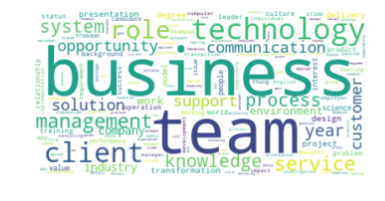

Cluster 1:
Number of Recordsr 38:
[('analytics', 46), ('science', 40), ('degree', 30), ('year', 30), ('analysis', 28), ('communication', 22), ('knowledge', 21), ('statistic', 21), ('business', 21), ('computer', 20)]


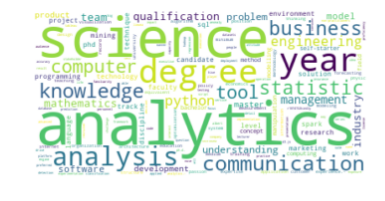

Cluster 2:
Number of Recordsr 55:
[('computer', 64), ('science', 49), ('research', 37), ('phd', 31), ('programming', 29), ('engineering', 29), ('degree', 28), ('policy', 28), ('criterion', 26), ('python', 26)]


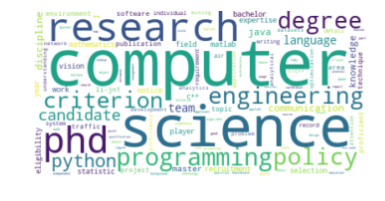

Cluster 3:
Number of Recordsr 66:
[('science', 67), ('computer', 64), ('system', 62), ('knowledge', 59), ('python', 45), ('engineering', 42), ('language', 41), ('year', 40), ('degree', 39), ('programming', 35)]


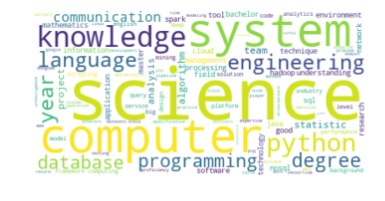

Cluster 4:
Number of Recordsr 38:
[('development', 64), ('software', 34), ('java', 32), ('team', 31), ('knowledge', 29), ('year', 27), ('technology', 25), ('python', 23), ('degree', 21), ('tool', 20)]


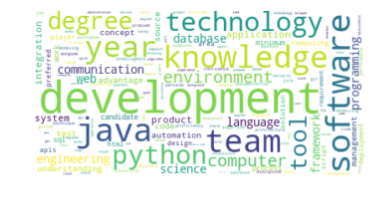

In [59]:
ClusterCloestWordsReturn(5,10)

# Visualization - Clustering Performance

In [60]:
# dist is defined as 1 - the cosine similarity of each document.
dist = 1 - cosine_similarity(tfidf)

# convert two components as we're plotting points in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [61]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a',4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Business Manager', 
                 1: 'Business Analyst', 
                 2: 'Researcher & Assistant', 
                 3: 'Data Engineer', 
                 4: 'Developer'
                }

In [62]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [63]:
clusters = km.labels_.tolist()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=title)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot



In [43]:

# #some ipython magic to show the matplotlib plots inline
# %matplotlib inline 

# #create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=title)) 

# #group by cluster
# groups = df.groupby('label')

# # set up plot
# fig, ax = plt.subplots(figsize=(17, 9)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# #iterate through groups to layer the plot
# #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
# for name, group in groups:
#     ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#             label=cluster_names[name], color=cluster_colors[name], 
#             mec='none')
#     ax.set_aspect('auto')
#     ax.tick_params(\
#         axis= 'x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom='off',      # ticks along the bottom edge are off
#         top='off',         # ticks along the top edge are off
#         labelbottom='off')
#     ax.tick_params(\
#         axis= 'y',         # changes apply to the y-axis
#         which='both',      # both major and minor ticks are affected
#         left='off',      # ticks along the bottom edge are off
#         top='off',         # ticks along the top edge are off
#         labelleft='off')
    
# ax.legend(numpoints=1)  #show legend with only 1 point

# #add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  
    
# # plt.show() #show the plot